# Prep

In [8]:
# @title Importing and Cleaning the Data

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from google.colab import drive
drive.mount('/content/drive')
# Specify the path to the file
file_path = '/content/drive/My Drive/loan_data_2007_2014.csv'

# Read the CSV file into a DataFrame
loan_data = pd.read_csv(file_path)

#with pd.option_context('display.max_columns', None):
#  display(loan_data.head(5))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-8-750f8d73a625>:16: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  loan_data = pd.read_csv(file_path)


In [9]:
# @title Cleanup

## Drop all-null columns (17 columns)
loan_data = loan_data.dropna(axis = 'columns', how = 'all')

## Merge the "Does not meet the credit policy" values into their respective simpler names
loan_data['loan_status'] = np.where((loan_data['loan_status'] == "Does not meet the credit policy. Status:Fully Paid"), "Fully Paid", loan_data['loan_status'])
loan_data['loan_status'] = np.where((loan_data['loan_status'] == "Does not meet the credit policy. Status:Charged Off"), "Charged Off", loan_data['loan_status'])

## Well rip that we actually do have defaults in our loans, but our model will still be a proof of concept just as well.
## Merge these two together (it's only ~800 defaults)
loan_data['loan_status'] = np.where((loan_data['loan_status'] == "Default"), "Charged Off", loan_data['loan_status'])

# @title Clean data columns to what we can actually use

## Ignore in-progress loans since only completed loans yet have an outcome
loan_cleanup = loan_data.query('loan_status == "Fully Paid" | loan_status == "Charged Off"').reset_index()

loan_cleanup.drop(columns = ['index'], inplace = True)

## Drop unusable columns (11 columns)
loan_cleanup = loan_cleanup.drop(columns = ["Unnamed: 0", "id", "member_id", "url", "desc", "emp_title","recoveries" ,"collection_recovery_fee", "pymnt_plan", "out_prncp",'out_prncp_inv'])

## Drop columns with single values (combined objects and floats code) (3 columns)
loan_cleanup = loan_cleanup.drop(columns = ["title", "application_type", 'policy_code'])

## Drop columns with obvious causal correlation to other columns (keep 1 column for each correlation "relationship") (4 columns)
loan_cleanup.drop(['loan_amnt','funded_amnt_inv','grade','total_pymnt_inv'], axis = 1,inplace = True)

## At this point we should have 40 columns ##


## Convert dates to actual dates  **Days can be ignored
loan_cleanup['earliest_cr_line'].fillna(loan_cleanup['issue_d'],inplace= True) ## Fill nulls with when the loan was initiated
loan_cleanup['earliest_cr_line'] = pd.to_datetime(loan_data['earliest_cr_line'], format='%b-%y',errors='coerce')

loan_cleanup['issue_d'] = pd.to_datetime(loan_data['issue_d'], format='%b-%y',errors='coerce')
loan_cleanup['last_pymnt_d'] = pd.to_datetime(loan_data['last_pymnt_d'], format='%b-%y',errors='coerce')  ## Nulls left untouched
loan_cleanup['next_pymnt_d'] = pd.to_datetime(loan_data['next_pymnt_d'], format='%b-%y',errors='coerce')  ## Nulls left untouched

loan_cleanup['last_credit_pull_d'].fillna('Jan-16', inplace = True) ## Date this place stated publishing data
loan_cleanup['last_credit_pull_d'] = pd.to_datetime(loan_data['last_credit_pull_d'], format='%b-%y',errors='coerce')

##  Transform term to an int
loan_cleanup['term'] = pd.to_numeric(loan_cleanup['term'].str.extract('(\d+)')[0])     ## Thank you Vishnu


## Replace null values with reasonable approximations
loan_cleanup['emp_length'].fillna('< 1 year', inplace = True)

loan_cleanup['annual_inc'].fillna(loan_cleanup['annual_inc'].median(), inplace=True)  ## Used Common Value rather than 0
##loan_cleanup['annual_inc'].fillna(0, inplace = True)

loan_cleanup['delinq_2yrs'].fillna(0, inplace =  True)
loan_cleanup['inq_last_6mths'].fillna(0, inplace =  True)
loan_cleanup['open_acc'].fillna(1, inplace =  True)
loan_cleanup['pub_rec'].fillna(0, inplace =  True)
loan_cleanup['total_acc'].fillna(1, inplace =  True)
loan_cleanup['acc_now_delinq'].fillna(0, inplace =  True)
#loan_cleanup['mths_since_last_delinq']
#loan_cleanup['mths_since_last_record']
loan_cleanup['revol_util'].fillna(58.0, inplace =  True)
loan_cleanup['collections_12_mths_ex_med'].fillna(0,inplace = True)
#loan_cleanup['mths_since_last_major_derog']
loan_cleanup['tot_coll_amt'].fillna(0, inplace = True)
loan_cleanup['tot_cur_bal'].fillna(0, inplace = True)
loan_cleanup['total_rev_hi_lim'].fillna(loan_cleanup['funded_amnt'], inplace = True)


## Added Cleanup Steps ##

## Fixes decimal imprecision in this column specifically for some reason
loan_cleanup['total_pymnt'] = loan_cleanup['total_pymnt'].round(2)

# Moves forward the target column so that it can be viewed more easily
loan_cleanup.insert(2, 'loan_status', loan_cleanup.pop('loan_status'))

## Exploratory Trend Analysis Columns ( +9 Columns )
loan_cleanup.insert(loan_cleanup.columns.get_loc('dti') + 1, 'loan_to_income_ratio', loan_cleanup['funded_amnt'] / loan_cleanup['annual_inc'])
loan_cleanup.insert(loan_cleanup.columns.get_loc('dti') + 1, 'installment_to_income_ratio', loan_cleanup['installment'] / loan_cleanup['annual_inc'])
## Adds a column to show us how much money we lost by allowing this loan.
## THIS NUMBER IS [BOTTOM] CAPPED AT 0. ##
loan_cleanup.insert(loan_cleanup.columns.get_loc('funded_amnt') + 1,
                    'loss_on_investment',
                    np.minimum(0,
                              ## The two methods of calculating losses should be identical, yet aren't.  Here we're assuming the largest possible loss is accurate.
                              loan_cleanup['total_pymnt'] - loan_cleanup['funded_amnt'],
                              loan_cleanup['total_rec_prncp'] + loan_cleanup['total_rec_int'] - loan_cleanup['funded_amnt']
                              )
                    )
# Splitting the issue date column into its constituent parts month and year (previously represented as Dec-11, now as [12] and [2011]).  Allows for month-level analysis.
loan_cleanup.insert(loan_cleanup.columns.get_loc('issue_d') + 1, 'issue_month', loan_cleanup['issue_d'].dt.month)
loan_cleanup.insert(loan_cleanup.columns.get_loc('issue_d') + 1, 'issue_year', loan_cleanup['issue_d'].dt.year)
loan_cleanup.drop(columns=['issue_d'], inplace = True)



# For columns with nulls intentionally left in, keeps a boolean record of them in case it's useful for models
loan_cleanup.insert(loan_cleanup.columns.get_loc('mths_since_last_delinq') + 1 , 'has_delinq', loan_cleanup['mths_since_last_delinq'].notnull())
loan_cleanup.insert(loan_cleanup.columns.get_loc('mths_since_last_record') + 1 , 'has_record', loan_cleanup['mths_since_last_record'].notnull())
loan_cleanup.insert(loan_cleanup.columns.get_loc('last_pymnt_d') + 1 , 'has_last_pymnt_d', loan_cleanup['last_pymnt_d'].notnull())
loan_cleanup.insert(loan_cleanup.columns.get_loc('next_pymnt_d') + 1 , 'has_next_pymnt_d', loan_cleanup['next_pymnt_d'].notnull())
loan_cleanup.insert(loan_cleanup.columns.get_loc('mths_since_last_major_derog') + 1 , 'has_derog', loan_cleanup['mths_since_last_major_derog'].notnull())

## Should now be at 49 columns ##

loan_cleanup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230795 entries, 0 to 230794
Data columns (total 49 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   funded_amnt                  230795 non-null  int64         
 1   loss_on_investment           230795 non-null  float64       
 2   term                         230795 non-null  int64         
 3   loan_status                  230795 non-null  object        
 4   int_rate                     230795 non-null  float64       
 5   installment                  230795 non-null  float64       
 6   sub_grade                    230795 non-null  object        
 7   emp_length                   230795 non-null  object        
 8   home_ownership               230795 non-null  object        
 9   annual_inc                   230795 non-null  float64       
 10  verification_status          230795 non-null  object        
 11  issue_year                

In [10]:
# @title Drop things that are only available after the fact (It would be nice to be able to predict what they are, though.)
post_drop = loan_cleanup.drop(columns = ['last_pymnt_d','has_last_pymnt_d','next_pymnt_d','has_next_pymnt_d','last_pymnt_amnt','total_pymnt',\
                                         'total_rec_prncp','total_rec_int','total_rec_late_fee','loss_on_investment'])

In [116]:
# @title Winsorizing our data provided no benefits to accuracy
#from scipy.stats.mstats import winsorize

#scaledData = post_drop.copy().reset_index().drop(columns = ['index'])

#for col in scaledData.drop(columns = ['funded_amnt','term','int_rate','installment']).columns:
#  if (scaledData[col].dtype == 'float64') or (scaledData[col].dtype == 'int64'):
#      print(col)
#      winsorize(scaledData['annual_inc'], limits=[0.05, 0.05],inplace = True)

# More Prep

In [11]:
# @title Imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import classification_report
from sklearn.utils import shuffle

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, VotingClassifier, BaggingClassifier
from sklearn.svm import SVC

In [12]:
# @title Encoding categorical values as ints
labels = OrdinalEncoder(encoded_missing_value = -1)

categorical_data = post_drop.copy().reset_index().drop(columns = ['index'])

categorical_columns = ['sub_grade','emp_length','home_ownership','verification_status','purpose','zip_code','addr_state','initial_list_status']

categorical_values = pd.DataFrame(labels.fit_transform(categorical_data[categorical_columns]),columns = categorical_columns)
categorical_data[categorical_columns] = categorical_values

#categorical_data.info()

In [13]:
# @title Splitting Dates into Years and Months
dateless = categorical_data.copy()

dateless.insert(categorical_data.columns.get_loc('earliest_cr_line') + 1, 'earliest_cr_line_month', categorical_data['earliest_cr_line'].dt.month)
dateless.insert(categorical_data.columns.get_loc('earliest_cr_line') + 1, 'earliest_cr_line_year', categorical_data['earliest_cr_line'].dt.year)
dateless.drop(columns=['earliest_cr_line'], inplace = True)

dateless.insert(categorical_data.columns.get_loc('last_credit_pull_d') + 1, 'last_credit_pull_month', categorical_data['last_credit_pull_d'].dt.month)
dateless.insert(categorical_data.columns.get_loc('last_credit_pull_d') + 1, 'last_credit_pull_year', categorical_data['last_credit_pull_d'].dt.year)
dateless.drop(columns=['last_credit_pull_d'], inplace = True)

#dateless.info()

In [15]:
nanless = dateless.copy().dropna(axis='columns', how = 'any')

nanless.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230795 entries, 0 to 230794
Data columns (total 34 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   funded_amnt                  230795 non-null  int64  
 1   term                         230795 non-null  int64  
 2   loan_status                  230795 non-null  object 
 3   int_rate                     230795 non-null  float64
 4   installment                  230795 non-null  float64
 5   sub_grade                    230795 non-null  float64
 6   emp_length                   230795 non-null  float64
 7   home_ownership               230795 non-null  float64
 8   annual_inc                   230795 non-null  float64
 9   verification_status          230795 non-null  float64
 10  issue_year                   230795 non-null  int64  
 11  issue_month                  230795 non-null  int64  
 12  purpose                      230795 non-null  float64
 13 

In [16]:
# @title Splitting our data
X, testX, Y, testY = train_test_split(categorical_data.drop(columns = ['loan_status']),categorical_data['loan_status'], train_size=0.7, test_size=0.3)

dateless_X, dateless_testX, dateless_Y, dateless_testY = train_test_split(dateless.drop(columns = ['loan_status']),dateless['loan_status'], train_size=0.7, test_size=0.3)

nanless_X,nanless_testX, nanless_Y,nanless_testY = train_test_split(nanless.drop(columns = ['loan_status']), nanless['loan_status'], train_size = 0.7, test_size = 0.3)


In [17]:
# @title Make our training data equally balanced (Leave TestX and TestY alone so that it can be independent from these changes)

rejoinedNanless = nanless_X.join(nanless_Y)

Defaults = rejoinedNanless.query('loan_status == "Charged Off"')
FullPays = rejoinedNanless.query('loan_status == "Fully Paid" ').sample(Defaults['loan_status'].count())

jointSmaller = shuffle(pd.concat([Defaults, FullPays], axis=0))
jointSmaller['loan_status'].value_counts()

balanced_X = jointSmaller.drop(columns = ['loan_status'])
balanced_Y = jointSmaller['loan_status']

balanced_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61680 entries, 170337 to 100227
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   funded_amnt                  61680 non-null  int64  
 1   term                         61680 non-null  int64  
 2   int_rate                     61680 non-null  float64
 3   installment                  61680 non-null  float64
 4   sub_grade                    61680 non-null  float64
 5   emp_length                   61680 non-null  float64
 6   home_ownership               61680 non-null  float64
 7   annual_inc                   61680 non-null  float64
 8   verification_status          61680 non-null  float64
 9   issue_year                   61680 non-null  int64  
 10  issue_month                  61680 non-null  int64  
 11  purpose                      61680 non-null  float64
 12  zip_code                     61680 non-null  float64
 13  addr_state

# Step 1:  Predicting Whether Something Is a Default or Not

## Logistic Regression
About 25% accurate for predicting "Charged Off" & 86% for "Fully Paid" \
Catches more "Charged Off"s accurately than it catches "Fully Paid"s

In [168]:
# @title Model Analysis
log_reg = LogisticRegression()
log_reg.fit(balanced_X, balanced_Y)

# Predictions
y_pred = log_reg.predict(nanless_testX)

# Performance
print(classification_report(nanless_testY, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

 Charged Off       0.24      0.64      0.35     13100
  Fully Paid       0.87      0.53      0.66     56139

    accuracy                           0.56     69239
   macro avg       0.55      0.59      0.51     69239
weighted avg       0.75      0.56      0.60     69239



In [164]:
# @title Feature Importances
importances = log_reg.coef_[0]
names = log_reg.feature_names_in_
df = pd.DataFrame(zip(names,np.abs(importances)),columns = ['names','importances'])

display(df.sort_values('importances', ascending = False))

,names,importances
3,installment,2.839557e-04
9,issue_year,1.898274e-04
12,zip_code,1.772520e-04
24,revol_util,1.693746e-04
4,sub_grade,1.334609e-04
1,term,1.180813e-04
2,int_rate,8.855575e-05
14,dti,5.877850e-05
0,funded_amnt,5.820016e-05
30,tot_coll_amt,2.462381e-05


## Decision Trees
About 30% accurate for predicting "Charged Off" & 88% for "Fully Paid"

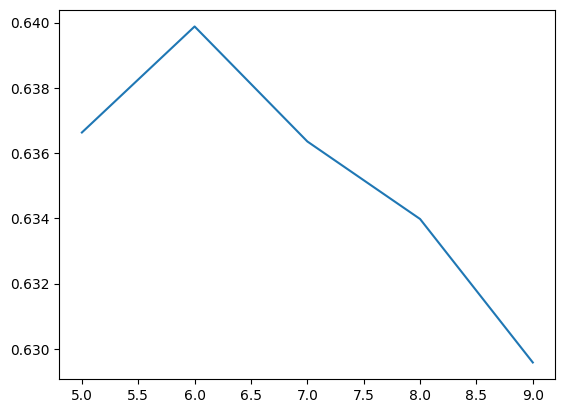

In [93]:
# @title HyperParameter Tuning: **Max depth - Best score at 6** (took 5 mins)

accuracy = []
depths = [x for x in range(5,10)]##range(1,30)] ##range(1,200,10)]

for depth in depths:
  DT = DecisionTreeClassifier(max_depth = depth)
  accuracy.append(cross_val_score(DT, balanced_X, balanced_Y, cv = 5).mean())


plt.plot(depths,accuracy)

In [102]:
# @title Model Analysis
dTree = DecisionTreeClassifier(max_depth = 6)

dTree.fit(balanced_X, balanced_Y)

# Predictions
y_pred = dTree.predict(nanless_testX)

# Performance
print(classification_report(nanless_testY, y_pred))

              precision    recall  f1-score   support

 Charged Off       0.29      0.65      0.40     13108
  Fully Paid       0.88      0.63      0.73     56131

    accuracy                           0.63     69239
   macro avg       0.59      0.64      0.57     69239
weighted avg       0.77      0.63      0.67     69239



In [157]:
# @title Feature Importances
importances = dTree.feature_importances_
names = dTree.feature_names_in_
df = pd.DataFrame(zip(names,importances),columns = ['names','importances'])

display(df.sort_values('importances', ascending = False))

,names,importances
4,sub_grade,0.542638
2,int_rate,0.181169
16,loan_to_income_ratio,0.108562
7,annual_inc,0.076325
14,dti,0.044298
1,term,0.008458
3,installment,0.006971
11,purpose,0.004609
12,zip_code,0.004577
31,tot_cur_bal,0.004350


## Random Forest
About 30% accurate for predicting "Charged Off" & 89% for "Fully Paid"

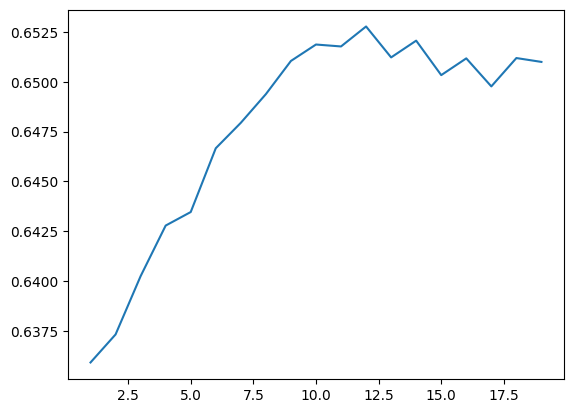

In [95]:
# @title HyperParameter Tuning:  **max_depth - Diminished returns after 12** (took 1 hour to run)
accuracy = []
depths = [x for x in range(1,20)]

for depth in depths:
  RF = RandomForestClassifier(max_depth = depth)
  accuracy.append(cross_val_score(RF, balanced_X, balanced_Y, cv = 5).mean())


plt.plot(depths,accuracy)

In [100]:
# @title HyperParameter Tuning:  **max_samples - our highest accuracy (at 33) was lower than just not putting anything in**
for i in range(1, len(balanced_X.columns) +1):
  accuracy = cross_val_score(RandomForestClassifier(max_depth = 12, max_samples = i,bootstrap = True, oob_score = True), balanced_X, balanced_Y,cv = 5).mean()
  print(f'n_estimators: {i}, average accuracy: {accuracy}')


n_estimators: 1, average accuracy: 0.5
n_estimators: 2, average accuracy: 0.5276147678524274
n_estimators: 3, average accuracy: 0.5607620307963831
n_estimators: 4, average accuracy: 0.5691893289567211
n_estimators: 5, average accuracy: 0.5708074256386391
n_estimators: 6, average accuracy: 0.5877118714478528
n_estimators: 7, average accuracy: 0.6115889953305896
n_estimators: 8, average accuracy: 0.6044874104232861
n_estimators: 9, average accuracy: 0.6129160562560878
n_estimators: 10, average accuracy: 0.6151157560365325
n_estimators: 11, average accuracy: 0.624223416827007
n_estimators: 12, average accuracy: 0.6191761989633495
n_estimators: 13, average accuracy: 0.6102147069899688
n_estimators: 14, average accuracy: 0.6143070086321429
n_estimators: 15, average accuracy: 0.6279280794570938
n_estimators: 16, average accuracy: 0.6307266024499429
n_estimators: 17, average accuracy: 0.6292707145042764
n_estimators: 18, average accuracy: 0.6322472375527597
n_estimators: 19, average accuracy:

In [102]:
# @title HyperParameter Tuning:  **criterion (no significant difference, stick with default)**
models = ['gini', 'entropy', 'log_loss']
for model in models:
  accuracy = cross_val_score(RandomForestClassifier(max_depth = 12, criterion = model, min_samples_leaf = 30), balanced_X, balanced_Y,cv = 5).mean()
  print(f'criterion: {model}, average accuracy: {accuracy}')


criterion: gini, average accuracy: 0.6528406894399237
criterion: entropy, average accuracy: 0.6533583566016181
criterion: log_loss, average accuracy: 0.6518538935683653


In [497]:
# @title Model Analysis
rForest = RandomForestClassifier(max_depth = 12)

rForest.fit(balanced_X, balanced_Y)

# Predictions
y_pred = rForest.predict(nanless_testX)

# Performance
print(classification_report(nanless_testY, y_pred))

              precision    recall  f1-score   support

 Charged Off       0.30      0.67      0.42     13228
  Fully Paid       0.89      0.64      0.74     56011

    accuracy                           0.64     69239
   macro avg       0.60      0.65      0.58     69239
weighted avg       0.78      0.64      0.68     69239



In [155]:
# @title Feature Importances
importances = rForest.feature_importances_
names = rForest.feature_names_in_
df = pd.DataFrame(zip(names,importances),columns = ['names','importances'])

display(df.sort_values('importances', ascending = False))

,names,importances
2,int_rate,0.153395
4,sub_grade,0.117686
16,loan_to_income_ratio,0.063851
14,dti,0.060449
15,installment_to_income_ratio,0.055602
7,annual_inc,0.051313
24,revol_util,0.045751
1,term,0.042472
23,revol_bal,0.037231
3,installment,0.036611


## SVC
About 25% accurate for predicting "Charged Off" & 86% for "Fully Paid"

In [126]:
# @title HyperParameter Tuning: **kernal (Linear takes too long to complete, RBF and Poly outperform Sigmoid but are equivalent)**
sample = nanless.sample(10000)
smallX,smallTestX,smallY,smallTestY = train_test_split(sample.drop(columns =['loan_status']),sample['loan_status'], train_size = 0.7,test_size = 0.3)
#display(smallX.head(5))

orig_kernel = ['rbf','poly','sigmoid'] ## RBF and Poly are equivalent, sigmoid is worse
## orig_kernel = ['linear'] takes too long to complete
for kern in orig_kernel:
  model = SVC(kernel=kern, degree = 2)
  model.fit(smallX,smallY)
  print(f'Kernel: {kern}, score:{model.score(smallTestX,smallTestY)}')

Kernel: rbf, score:0.8186666666666667
Kernel: poly, score:0.8186666666666667
Kernel: sigmoid, score:0.698


In [104]:
# @title Model Analysis
svc = SVC(kernel = 'rbf')

svc.fit(balanced_X, balanced_Y)

# Predictions
y_pred = svc.predict(nanless_testX)

# Performance
print(classification_report(nanless_testY, y_pred))

              precision    recall  f1-score   support

 Charged Off       0.25      0.59      0.35     13160
  Fully Paid       0.86      0.59      0.70     56079

    accuracy                           0.59     69239
   macro avg       0.56      0.59      0.53     69239
weighted avg       0.75      0.59      0.63     69239



## XGBoost
About 31% accurate for predicting "Charged Off" & 89% for "Fully Paid"

In [21]:
# @title HyperParameter Tuning: **Best Depth and learning rate** respectively: **11 & 0.05**

for depth in [x for x in range(1,20)]:
  print(f'Depth: {depth}')
  for rate in [0.01, 0.005, 0.001]:#[1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001]:
    model2 = HistGradientBoostingClassifier(learning_rate=rate , max_depth = depth)
    print(f'\t Rate: {rate}, score:{cross_val_score(model2, balanced_X, balanced_Y, cv = 5).mean()}')

Depth: 1
	 Rate: 0.01, score:0.630750342074914
	 Rate: 0.005, score:0.6290009777991655
	 Rate: 0.001, score:0.6289361401303821
Depth: 2
	 Rate: 0.01, score:0.6356745194153438
	 Rate: 0.005, score:0.6308475119984319
	 Rate: 0.001, score:0.6278509730071128
Depth: 3
	 Rate: 0.01, score:0.640452968762663
	 Rate: 0.005, score:0.6388007547332377
	 Rate: 0.001, score:0.6363062531317896
Depth: 4
	 Rate: 0.01, score:0.6451990202645985
	 Rate: 0.005, score:0.6417164204537986
	 Rate: 0.001, score:0.6389952060843774
Depth: 5
	 Rate: 0.01, score:0.6461546602851687
	 Rate: 0.005, score:0.6458469286351958
	 Rate: 0.001, score:0.6397079390056284
Depth: 6
	 Rate: 0.01, score:0.647952677081045
	 Rate: 0.005, score:0.646284296268346
	 Rate: 0.001, score:0.6396593310871421
Depth: 7
	 Rate: 0.01, score:0.6484062246155988
	 Rate: 0.005, score:0.6452638107081144
	 Rate: 0.001, score:0.6433200606718754
Depth: 8
	 Rate: 0.01, score:0.6484709966937328
	 Rate: 0.005, score:0.6451828259332519
	 Rate: 0.001, score

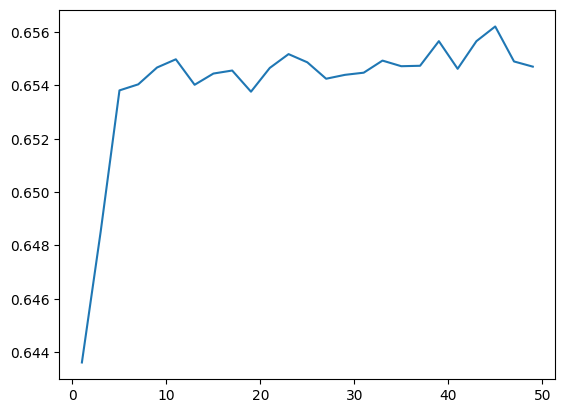

In [25]:
# @title **Checking a Larger Depth range** to see any trends:  Very slight increase after 11, perhaps peaking at 47. **Stick with 11,** since only a .002% increase
accuracy = []
depths = [x for x in range(1,50,2)]

for depth in depths:
  hgb = HistGradientBoostingClassifier(learning_rate=0.05 , max_depth = depth)
  accuracy.append(cross_val_score(hgb, balanced_X, balanced_Y, cv = 5).mean())

plt.plot(depths,accuracy)

In [478]:
# @title Model Analysis
hgb = HistGradientBoostingClassifier(learning_rate=0.05 , max_depth = 11)
hgb.fit(balanced_X, balanced_Y)

# Predictions
y_pred = hgb.predict(nanless_testX)

# Performance
print(classification_report(nanless_testY, y_pred))

              precision    recall  f1-score   support

 Charged Off       0.30      0.67      0.42     13228
  Fully Paid       0.89      0.64      0.75     56011

    accuracy                           0.65     69239
   macro avg       0.60      0.65      0.58     69239
weighted avg       0.78      0.65      0.68     69239



## Ensembles

In [136]:
# @title Bagging Regressor (took 55 minutes to calculate, mostly for SVC)

Bnames = []
Bregressors = []

# using default of 10 estimator runs

Bregressors.append(BaggingClassifier( LogisticRegression(), n_estimators = 10)) # Linear Regression
Bnames.append("Bag(LR x 3)")
Bregressors.append(BaggingClassifier( DecisionTreeClassifier(max_depth = 6), n_estimators = 10)) # Decision Trees
Bnames.append("Bag(DT x 3)")
Bregressors.append(BaggingClassifier( RandomForestClassifier(max_depth = 12), n_estimators = 10)) # Random Forest
Bnames.append("Bag(RF x 3)")
Bregressors.append(BaggingClassifier( SVC(kernel = 'rbf'), n_estimators = 10)) # svc - rbf
Bnames.append("Bag(SVR x 3)")
Bregressors.append(BaggingClassifier( HistGradientBoostingClassifier(learning_rate=0.05 , max_depth = 11), n_estimators = 10)) # xgb - rbf
Bnames.append("Bag(XGB x 3)")

for model, m_name in zip(Bregressors, Bnames):
  model.fit(balanced_X, balanced_Y)
  print(f'\t {m_name}, {model.score(nanless_testX, nanless_testY)}' )

#Bag(LR x 3), 0.5624431317610018
#Bag(DT x 3), 0.6423836277242595
#Bag(RF x 3), 0.6731321942835685
#Bag(SVR x 3), 0.5803087855110559
#Bag(XGB x 3), 0.6557720359912766

	 Bag(SVR x 3), 0.5803087855110559


In [129]:
# @title Voting Classifiers between our classes (took 50 minutes to calculate, mostly for SVC)
classifiers = [ LogisticRegression(), SVC(kernel = 'rbf') , DecisionTreeClassifier(max_depth = 6), RandomForestClassifier(max_depth = 12), HistGradientBoostingClassifier(learning_rate=0.05 , max_depth = 11)]
Vnames = []
ensembles = []

# Voting amongst all base learner classifiers
ensembles.append( VotingClassifier( [(type(x).__name__, x) for x in classifiers], n_jobs = -1 ) )
Vnames.append('Vote(LR,SVC,DT,RF, XGB)')

# for each base learner use 3 runs for each to compare to combination
ensembles.append( VotingClassifier([(x, LogisticRegression() ) for x in ['LR1','LR2','LR3'] ]))
Vnames.append('Vote(LR x 3)')
ensembles.append( VotingClassifier([(x, DecisionTreeClassifier(max_depth = 6) ) for x in ['DT1','DT2','DT3'] ]))
Vnames.append('Vote(DT x 3)')
ensembles.append( VotingClassifier([(x, SVC(kernel = 'rbf') ) for x in ['SVR1','SVR2','SVR3'] ]))
Vnames.append('Vote(SVC x 3)')

for model, m_name in zip(ensembles, Vnames):
    model.fit(balanced_X, balanced_Y)
    print(f'{m_name}, {model.score(nanless_testX, nanless_testY)}' )


#Vote(LR,SVC,DT,RF, XGB), 0.640693828622597
#Vote(LR x 3), 0.5738962145611577
#Vote(DT x 3), 0.6162567339216337
#Vote(SVC x 3), 0.5893643755686824

	 Vote(LR,SVC,DT,RF, XGB), 0.651598087782897


In [472]:
log_reg = LogisticRegression()
dTree = DecisionTreeClassifier(max_depth = 6)
rForest = RandomForestClassifier(max_depth = 12)
svc = SVC(kernel = 'rbf')
hgb = HistGradientBoostingClassifier(learning_rate=0.05 , max_depth = 11)
xgbBag = BaggingClassifier( HistGradientBoostingClassifier(learning_rate=0.05 , max_depth = 11), n_estimators = 10)
rfBag = BaggingClassifier( RandomForestClassifier(max_depth = 12), n_estimators = 10)


classifiers = [ ('LR',log_reg),
                #('SVC', svc),
                ('DT',dTree),
                ('RF',rForest),
                ('HGB',hgb),
                ('GBB',xgbBag),
                ('RFB',rfBag)
               ]
votes = VotingClassifier( classifiers )

votes.fit(balanced_X,balanced_Y)

# Predictions
y_pred = votes.predict(nanless_testX)

# Performance
print(classification_report(nanless_testY, y_pred))

              precision    recall  f1-score   support

 Charged Off       0.30      0.69      0.42     13228
  Fully Paid       0.89      0.62      0.73     56011

    accuracy                           0.63     69239
   macro avg       0.60      0.65      0.57     69239
weighted avg       0.78      0.63      0.67     69239



#Step 2: Maximizing the Loan Amount Given that we defaulted

In [ ]:
# @title Imports
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

## Method 1 - Stepping Down from a Defaulted Amount until not Default

In [726]:
# @title Functions required to step downwards until reaching a likely repayment quantity
matrixSize = 9
def generateGrid(LoanAmount,IntRate):
  if LoanAmount < 200:
    quantityStepSize = 10
  elif LoanAmount < 1500:
    quantityStepSize = 100
  else:
    quantityStepSize = 1000

  rateStepSize = 1.0

  matrix = [
      [LoanAmount - quantityStepSize , IntRate - rateStepSize], [LoanAmount , IntRate - rateStepSize], [LoanAmount + quantityStepSize , IntRate - rateStepSize],
      [LoanAmount - quantityStepSize , IntRate ], [LoanAmount , IntRate], [LoanAmount + quantityStepSize , IntRate],
      [LoanAmount - quantityStepSize , IntRate + rateStepSize], [LoanAmount , IntRate + rateStepSize], [LoanAmount + quantityStepSize , IntRate + rateStepSize],
  ]
  return quantityStepSize, pd.DataFrame(data = matrix, columns = ['funded_amnt', 'int_rate'])

# Returns what the step down is, as well as what % of the results are "Fully Paid"
def accuracy(data, model):
  #model.fit(balanced_X, balanced_Y)
  data = pd.DataFrame(data, columns = balanced_X.columns)
  while data.shape[0] < 9:
    data = pd.concat([data,data.sample(1)], ignore_index= True)

  step, generatedGrid = generateGrid(data['funded_amnt'][0],data['int_rate'][0])
  data[['funded_amnt','int_rate']] = generatedGrid

  predictions = pd.DataFrame(model.predict(data),columns= ['value'])
  #display(predictions)

  return step, (predictions.query('value == "Fully Paid"').count()/matrixSize).value

# Model Must be PreFitted
def stepData(data,model):
  print(f'Initial Loan Request: {data["funded_amnt"].iloc[0]}')
  acc = 0.0
  while acc < 0.6 and data['funded_amnt'].iloc[0] > 0.0:
    step, acc = accuracy(data, model)
    if acc > 0.6:
      break
    if data['funded_amnt'].iloc[0] < 0.0:
      break

    data['funded_amnt'] -= step
    data['installment'] = round((data['funded_amnt'] / data['term']) * (1.0 + data['int_rate']/(36*60/data['term'])), 2)
    data['loan_to_income_ratio'] = data['funded_amnt'] / data['annual_inc']
    data['installment_to_income_ratio'] = data['installment'] / data['annual_inc']

  print(f'Suggested Loan Grant: {data["funded_amnt"].iloc[0]}')

  with pd.option_context('display.max_columns', None):
    display(data)

  return(data['funded_amnt'].iloc[0])

In [727]:
# @title Sample Execution Using Histogram Gradient Boost Model

# hgb = HistGradientBoostingClassifier(learning_rate=0.05 , max_depth = 11).fit(balanced_X, balanced_Y)

stepData(balanced_X.sample(1),hgb)

Initial Loan Request: 35000
Suggested Loan Grant: 35000


,funded_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_year,issue_month,purpose,zip_code,addr_state,dti,installment_to_income_ratio,loan_to_income_ratio,delinq_2yrs,inq_last_6mths,has_delinq,has_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,has_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
127871,35000,60,21.98,966.27,23.0,5.0,1.0,175000.0,1.0,2013,6,2.0,338.0,1.0,13.93,0.005522,0.2,0.0,0.0,True,False,8.0,0.0,48470,89.6,26.0,0.0,0.0,False,0.0,0.0,350283.0,53600.0


35000

## Method 2 - Linear approximation of Default Quantity, Given Default

In [717]:
# @title Crafting a dataset from "only defaults" I.E. GIVEN we defaulted, how much did we lose?

# Keep ['loss_on_investment']
dropColumns = ['last_pymnt_d','has_last_pymnt_d','next_pymnt_d','has_next_pymnt_d','last_pymnt_amnt','total_pymnt', 'total_rec_prncp','total_rec_int','total_rec_late_fee']

defaults = loan_cleanup.query('loan_status == "Charged Off" & loss_on_investment != 0').reset_index().drop(columns = (['index','loan_status'] + dropColumns))


categorical_values = pd.DataFrame(labels.transform(defaults[categorical_columns]),columns = categorical_columns)
defaults[categorical_columns] = categorical_values

defaults.dropna(axis='columns', how = 'any', inplace = True)

# For Regressing to Determine "Loss on investment"
X, testX, Y, testY = train_test_split(defaults.drop(columns = ['loss_on_investment']),defaults['loss_on_investment'], train_size=0.7, test_size=0.3)

In [725]:
# @title Seeing Potential Trends in the Installment v interest rate data
scaler = StandardScaler()

scaled = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

fig = px.scatter(scaled, y='installment', x='int_rate', color= Y,
                 title='Installment vs. Interest Rate',
                 labels={'installment': 'Installment', 'int_rate': 'Interest Rate', 'color':' Scaled Amount Lost'},
                 width=800, height=800)
fig.show()

In [719]:
# @title Testing Linear Regression with 1 and 2 dimensional Transformations
linReg = LinearRegression()
polyReg = LinearRegression()

poly = PolynomialFeatures(2)
polyized = poly.fit_transform(X,Y)

model_1 = linReg.fit(X,Y)
y_pred_1 = model_1.predict(testX)

model_2 = polyReg.fit(polyized,Y)
y_pred_2 = model_2.predict(poly.transform(testX))

results = pd.DataFrame(zip(testX['funded_amnt'],testY,y_pred_1,y_pred_2), columns = ['loan amount','Y', 'prediction 1', 'prediction 2'])
results['diff1']= abs(results['Y'] - results['prediction 1'])
results['diff2']= abs(results['Y'] - results['prediction 2'])

print(f"Average Difference Between predicted and actual loss: {results['diff1'].sum() / results['diff1'].count()}")
print(f"Average Difference Between predicted and actual loss: {results['diff2'].sum() / results['diff2'].count()}")
print (r2_score(testY,y_pred_1))
print (r2_score(testY,y_pred_2))
display(results.sort_values('diff1', ascending = False))
print((results['loan amount'] < results['diff1']).value_counts())


Average Difference Between predicted and actual loss: 2476.0550654068475
Average Difference Between predicted and actual loss: 2396.8883790938794
0.6673988789441438
0.6370063421380887


,loan amount,Y,prediction 1,prediction 2,diff1,diff2
1386,35000,-731.60,-38113.873470,5724.072508,37382.273470,6455.672508
7348,35000,-852.60,-19534.342737,-16898.124568,18681.742737,16045.524568
12431,35000,-1528.16,-19757.138418,-18345.846592,18228.978418,16817.686592
1139,35000,-70.46,-17648.138473,-15223.792388,17577.678473,15153.332388
2391,35000,-1963.54,-19211.121468,-14621.483650,17247.581468,12657.943650
...,...,...,...,...,...,...
3673,35000,-17714.96,-17713.565167,-19017.028319,1.394833,1302.068319
1501,12800,-8434.87,-8435.964497,-8519.610366,1.094497,84.740366
10445,12000,-7633.00,-7632.133025,-7274.306624,0.866975,358.693376
2436,4825,-2598.33,-2597.946421,-3094.263462,0.383579,495.933462


False    12670
True        21
dtype: int64


In [ ]:
# @title Any interesting linear coefficient insights?

importances = model_1.coef_
names = model_1.feature_names_in_
df = pd.DataFrame(zip(names,np.abs(importances)),columns = ['names','importances'])

display(df.sort_values('importances', ascending = False))

In [553]:
# @title Testing Other Regressors:  **Stick with HistGradientBoostingRegressor**.  It's just way faster and more accurate.

# Takes 1 minute to fit
model_3 = RandomForestRegressor()
# Takes 1 second to fit, with slightly higher accuracy
model_4 = HistGradientBoostingRegressor()


model_3.fit(X,Y)
y_pred_3 = model_3.predict(testX)


model_4.fit(X,Y)
y_pred_4 = model_4.predict(testX)

results = pd.DataFrame(zip(testX['funded_amnt'],testY,y_pred_3,y_pred_4), columns = ['loan amount','Y', 'prediction 3', 'prediction 4'])
results['diff3']= abs(results['Y'] - results['prediction 3'])
results['diff4']= abs(results['Y'] - results['prediction 4'])

print(f"Average Difference Between predicted and actual loss: {results['diff3'].sum() / results['diff3'].count()}")
print(f"Average Difference Between predicted and actual loss: {results['diff4'].sum() / results['diff4'].count()}")
print (r2_score(testY,y_pred_3))
print (r2_score(testY,y_pred_4))
display(results.sort_values('loan amount', ascending = False))

Average Difference Between predicted and actual loss: 6150.738655771807
Average Difference Between predicted and actual loss: 2175.6484141912088
-0.7266318836346579
0.7337754597060642


,loan amount,Y,prediction 3,prediction 4,diff3,diff4
6559,35000,-15749.54,-7082.2847,-21856.108068,8667.2553,6106.568068
6288,35000,-17763.43,-8889.8990,-14412.168144,8873.5310,3351.261856
7253,35000,-17045.45,-587.1688,-13002.908179,16458.2812,4042.541821
2849,35000,-14719.89,-1996.8882,-11454.763280,12723.0018,3265.126720
9521,35000,-18414.12,-12580.5088,-18965.351232,5833.6112,551.231232
...,...,...,...,...,...,...
8314,1000,-98.61,-2309.1017,-893.567379,2210.4917,794.957379
8642,1000,-283.27,-6658.6736,-862.606043,6375.4036,579.336043
8739,1000,-594.19,-603.0521,-1177.603170,8.8621,583.413170
9035,1000,-856.04,-23021.0035,-2476.409676,22164.9635,1620.369676


## Step 2 Aggregated

In [549]:
# @title Data

# Keep ['loss_on_investment']
dropColumns = ['last_pymnt_d','has_last_pymnt_d','next_pymnt_d','has_next_pymnt_d','last_pymnt_amnt','total_pymnt', 'total_rec_prncp','total_rec_int','total_rec_late_fee']

defaults = loan_cleanup.query('loan_status == "Charged Off" & loss_on_investment != 0').reset_index().drop(columns = (['index','loan_status'] + dropColumns))

categorical_values = pd.DataFrame(labels.transform(defaults[categorical_columns]),columns = categorical_columns)
defaults[categorical_columns] = categorical_values

defaults.dropna(axis='columns', how = 'any', inplace = True)

# For Regressing to Determine "Loss on investment"
X, testX, Y, testY = train_test_split(defaults.drop(columns = ['loss_on_investment']),defaults['loss_on_investment'], train_size=0.7, test_size=0.3)

In [739]:
# @title Models

HGBRegression = HistGradientBoostingRegressor().fit(X,Y)

In [741]:
# @title Functions
def outputNewSuggestion(data,model):
  PrecalculatedAverageError = 2175.6484141912088
  anticipatedLoss = model.predict(data)[0]

  result = data['funded_amnt'].iloc[0] + anticipatedLoss

  return {'low': result - PrecalculatedAverageError, 'mid': result, 'high': result + PrecalculatedAverageError}

matrixSize = 9
def generateGrid(LoanAmount,IntRate):
  if LoanAmount < 200:
    quantityStepSize = 10
  elif LoanAmount < 1500:
    quantityStepSize = 100
  else:
    quantityStepSize = 1000

  rateStepSize = 1.0

  matrix = [
      [LoanAmount - quantityStepSize , IntRate - rateStepSize], [LoanAmount , IntRate - rateStepSize], [LoanAmount + quantityStepSize , IntRate - rateStepSize],
      [LoanAmount - quantityStepSize , IntRate ], [LoanAmount , IntRate], [LoanAmount + quantityStepSize , IntRate],
      [LoanAmount - quantityStepSize , IntRate + rateStepSize], [LoanAmount , IntRate + rateStepSize], [LoanAmount + quantityStepSize , IntRate + rateStepSize],
  ]
  return quantityStepSize, pd.DataFrame(data = matrix, columns = ['funded_amnt', 'int_rate'])

# Returns what the step down is, as well as what % of the results are "Fully Paid"
def accuracy(data, model):
  #model.fit(balanced_X, balanced_Y)
  data = pd.DataFrame(data, columns = balanced_X.columns)
  while data.shape[0] < 9:
    data = pd.concat([data,data.sample(1)], ignore_index= True)

  step, generatedGrid = generateGrid(data['funded_amnt'][0],data['int_rate'][0])
  data[['funded_amnt','int_rate']] = generatedGrid

  predictions = pd.DataFrame(model.predict(data),columns= ['value'])
  #display(predictions)

  return step, (predictions.query('value == "Fully Paid"').count()/matrixSize).value

# Model Must be PreFitted
def stepData(data,model):
  print(f'Initial Loan Request: {data["funded_amnt"].iloc[0]}')
  with pd.option_context('display.max_columns', None):
    display(data)

  acc = 0.0
  while acc < 0.6 and data['funded_amnt'].iloc[0] > 0.0:
    step, acc = accuracy(data, model)
    if acc > 0.6:
      break
    if data['funded_amnt'].iloc[0] < 0.0:
      break

    data['funded_amnt'] -= step
    data['installment'] = round((data['funded_amnt'] / data['term']) * (1.0 + data['int_rate']/(36*60/data['term'])), 2)
    data['loan_to_income_ratio'] = data['funded_amnt'] / data['annual_inc']
    data['installment_to_income_ratio'] = data['installment'] / data['annual_inc']

  print(f'Suggested Loan Grant: {data["funded_amnt"].iloc[0]}')
  return(data['funded_amnt'].iloc[0])

In [744]:
# @title Demonstrated Results
datum = X.sample(1)
print(f'Original Request: {datum["funded_amnt"].iloc[0]}')

suggestion = outputNewSuggestion(datum,HGBRegression)
if suggestion['mid'] < 0:
  print(f'Suggested Loan: {round(suggestion["high"] ,2)} (high)')
elif suggestion['mid'] > datum['funded_amnt'].iloc[0]:
  print(f'Suggested Loan: {round(suggestion["low"] ,2)} (low)')
else:
  print(f'Suggested Loan: {round(suggestion["mid"] ,2)} (mid)')

print("\n")
stepData(datum,hgb)

Original Request: 7925
Suggested Loan: 4066.82 (mid)


Initial Loan Request: 7925


,funded_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_year,issue_month,purpose,zip_code,addr_state,dti,installment_to_income_ratio,loan_to_income_ratio,delinq_2yrs,inq_last_6mths,has_delinq,has_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,has_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
921,7925,60,12.42,177.98,8.0,9.0,5.0,24636.0,1.0,2011,10,2.0,536.0,14.0,28.2,0.007224,0.321684,0.0,1.0,False,False,14.0,0.0,13379,65.3,23.0,0.0,0.0,False,0.0,0.0,0.0,7925.0


Suggested Loan Grant: -5


-5

In [752]:
# Whole Model Running:
exampleData = nanless_X.sample(1)

if hgb.predict(exampleData) == 'Charged Off':
  print(f'Original Request: {exampleData["funded_amnt"].iloc[0]}')

  suggestion = outputNewSuggestion(exampleData,HGBRegression)
  if suggestion['mid'] < 0:
    print(f'Suggested Loan: {round(suggestion["high"] ,2)} (high)')
  elif suggestion['mid'] > exampleData['funded_amnt'].iloc[0]:
    print(f'Suggested Loan: {round(suggestion["low"] ,2)} (low)')
  else:
    print(f'Suggested Loan: {round(suggestion["mid"] ,2)} (mid)')

  print("\n")
  stepData(exampleData,hgb)
else:
  print('Loan seems safe!')

Original Request: 30000
Suggested Loan: 8979.08 (mid)


Initial Loan Request: 30000


,funded_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_year,issue_month,purpose,zip_code,addr_state,dti,installment_to_income_ratio,loan_to_income_ratio,delinq_2yrs,inq_last_6mths,has_delinq,has_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,has_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
162547,30000,36,15.99,1054.57,16.0,2.0,5.0,450000.0,0.0,2013,3,11.0,82.0,33.0,2.24,0.002343,0.066667,0.0,3.0,True,True,8.0,1.0,24980,74.8,25.0,0.0,0.0,True,0.0,0.0,96629.0,57000.0


Suggested Loan Grant: 8000


# STILL TBD: Needs to be able to Fill in User Data, coming from the WebApp